# Part 3 ‑ Predictive modeling
Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

In [259]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

In [260]:
with open('ultimate_data_challenge.json') as logins_file:
    logins_string = json.load(logins_file)
    user_data_df = json_normalize(logins_string)

In [3]:
user_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Two points become evident when looking at the above. Three columns have null values and that signup_date and last_trip_date are not in datetime format. Let's convert signup_date and last_trip_date to datetime format.

In [4]:
user_data_df['signup_date'] = pd.to_datetime(user_data_df['signup_date'])
user_data_df['last_trip_date'] = pd.to_datetime(user_data_df['last_trip_date'])

In [5]:
user_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Replace null values with mean

In [56]:
user_data_df['avg_rating_of_driver'].fillna(user_data_df['avg_rating_of_driver'].mean(), inplace=True)
user_data_df['avg_rating_by_driver'].fillna(user_data_df['avg_rating_by_driver'].mean(), inplace=True)
user_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Now we can define the retained column by checking if a user had a trip in the past 30 days. The issue is that the date that the data was pulled is not mentioned so the best we can do is to assume that the date the data was pulled is the same as the last date that a user travelled. Therefore let us look at the last_trip_date column of the dataset 

In [6]:
user_data_df['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

As June is 30 days we will consider a user to be active/retained if that user had a trip in June 2014 or July 2014 ( need to include boundry case 2014-07-01 00:00:00 )

In [7]:
user_data_df['retained'] = user_data_df['last_trip_date'].dt.month >= 6
user_data_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [8]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.211-b12, mixed mode)
  Starting server from C:\Users\farbo\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\farbo\AppData\Local\Temp\tmp3u84mz15
  JVM stdout: C:\Users\farbo\AppData\Local\Temp\tmp3u84mz15\h2o_farbo_started_from_python.out
  JVM stderr: C:\Users\farbo\AppData\Local\Temp\tmp3u84mz15\h2o_farbo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.4
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_farbo_15ahdg
H2O cluster total nodes:,1
H2O cluster free memory:,1.745 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [9]:
h2o.remove_all()

In [10]:
hf = h2o.H2OFrame(user_data_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [11]:
hf.describe()

Rows:50000
Cols:13




,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
type,enum,int,time,real,real,time,enum,real,enum,real,real,real,enum
mins,,0.0,1388534400000.0,1.0,1.0,1388534400000.0,,0.0,,0.0,0.0,1.0,
mean,,2.278199999999998,1389877460352.002,4.601559291274633,1.0747638000000022,1397894524991.993,,8.849535999999942,,60.92608399999982,5.796826600000038,4.778158195947728,
maxs,,125.0,1391126400000.0,5.0,8.0,1404172800000.0,,100.0,,100.0,160.96,5.0,
sigma,,3.7926840692376356,756364650.5215249,0.6173384560411358,0.2223360089494666,5332520288.309384,,19.958810898131006,,37.081503405105295,5.707356703233388,0.44665179346562056,
zeros,,15390,0,0,0,0,,34409,,9203,150,0,
missing,0,0,0,8122,0,0,0,0,0,0,0,201,0
0,King's Landing,4.0,2014-01-25 00:00:00,4.7,1.1,2014-06-17 00:00:00,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0.0,2014-01-29 00:00:00,5.0,1.0,2014-05-05 00:00:00,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3.0,2014-01-06 00:00:00,4.3,1.0,2014-01-07 00:00:00,iPhone,0.0,False,100.0,0.77,5.0,False


In [279]:
train, test = hf.split_frame(ratios=[0.85], seed=1234)

In [342]:
model = H2OGeneralizedLowRankEstimator(k=6, init="svd", svd_method="power", loss="quadratic"
                                       , regularization_x="l2", regularization_y="l2", max_iterations=2000, gamma_x=2
                                       , gamma_y=1, impute_original=True, score_each_iteration=True, transform="normalize"
                                       , min_step_size=1e-5, loss_by_col=['categorical','categorical','logistic','hinge']
                                       , loss_by_col_idx=[0,6,8,12])

In [343]:
model.train(x=hf.columns, training_frame=train)

glrm Model Build progress: |██████████████████████████████████████████████| 100%


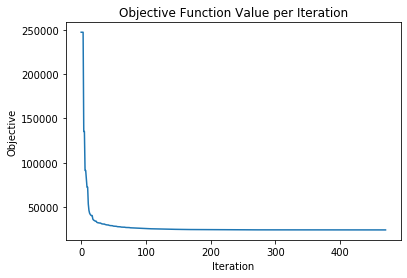

In [344]:
model_score = model.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [345]:
new_test = h2o.deep_copy(test, 'new_test')
new_test["retained"] = numpy.NaN
pred = model.predict(new_test)
pred['reconstr_retained'] = pred['reconstr_retained'].asfactor()

glrm prediction progress: |███████████████████████████████████████████████| 100%


[[4342  265]
 [ 888 2052]]
0.8472240625414071
              precision    recall  f1-score   support

       False       0.83      0.94      0.88      4607
        True       0.89      0.70      0.78      2940

    accuracy                           0.85      7547
   macro avg       0.86      0.82      0.83      7547
weighted avg       0.85      0.85      0.84      7547



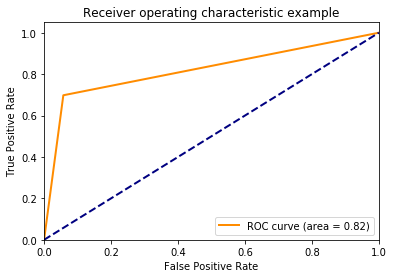

In [346]:
print(confusion_matrix(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained']))
print(accuracy_score(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained']))
print(classification_report(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained']))
fpr, tpr, thresholds = roc_curve(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained'])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [347]:
ultimate_y = model._model_json["output"]["archetypes"]
print(ultimate_y)


Archetypes: 

,,cityastapor,citykings_landing,citywinterfell,phone,phoneandroid,phoneiphone,ultimate_black_user,retained,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,Arch1,-1.663952,1.471418,-9.650211,-10.548426,14.878778,-13.063250,-15.803466,-9.517130,-0.096314,-0.047379,0.092572,0.066398,-1.527049,0.561457,-4.306382,-0.032013,0.034905
1,Arch2,6.805512,11.471478,-23.412220,-4.598025,-18.807460,14.511046,1.522265,8.369477,0.015577,0.167234,0.169258,0.041130,1.885129,0.424841,-1.608596,-0.046293,0.112556
2,Arch3,25.182496,-1.989538,-12.623908,11.036487,15.179965,-10.023975,9.238122,-6.421806,-0.054025,0.127091,0.117749,-0.013518,-1.931162,-0.129097,1.910877,0.017107,0.102988
3,Arch4,-3.860904,16.498300,-0.654986,14.317280,13.059166,-12.037182,13.173067,17.661529,0.049714,-0.007248,0.018870,0.019153,1.839379,0.212907,-2.093452,-0.036262,-0.018974
4,Arch5,4.939341,1.898617,-0.311504,7.150124,5.002135,1.107456,-31.053248,7.265366,0.006809,0.159111,-0.008002,0.008401,1.207187,0.097484,1.943350,-0.017802,-0.015306
5,Arch6,6.968541,-16.428982,2.352249,-8.977297,-0.961713,-3.457280,3.382484,13.655108,0.085990,0.139345,-0.116479,0.014752,4.107393,0.143387,-1.375357,-0.074554,-0.113946


In [104]:
model.score_history()

,,timestamp,duration,iterations,step_size,objective
0,,2019-09-16 11:23:02,0.087 sec,0.0,0.666667,1.756825e+07
1,,2019-09-16 11:23:02,0.121 sec,1.0,0.444444,1.756825e+07
2,,2019-09-16 11:23:02,0.151 sec,2.0,0.222222,1.756825e+07
3,,2019-09-16 11:23:02,0.181 sec,3.0,0.074074,1.756825e+07
